# Chest X-ray of Pneumonia

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as mpt
import os
import seaborn as sns
import tensorflow as ts

# Packages for data processing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Packages for deep learning model
from keras import Input, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, Activation, Dropout, MaxPooling2D, Flatten, Dense, Add

# Packages for visualization of results
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, PrecisionRecallDisplay, precision_recall_curve
import shap

## Pre-processing

### Data Visualization

NORMAL2-IM-1294-0001-0002.jpeg


(1260, 1400)

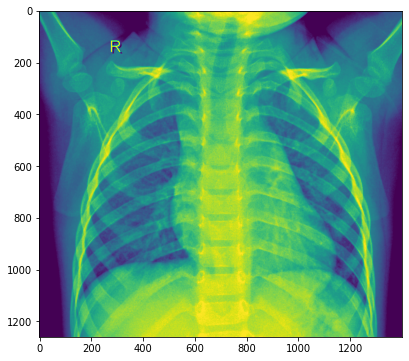

In [2]:
# images visualisation
print(os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/')[1]) # Show image name
train_norm_path = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
norm_im = mpt.imread(f'{train_norm_path}{os.listdir(train_norm_path)[1]}')
f = mpt.figure(figsize= (10,6))
img_plot = mpt.imshow(norm_im) # Show image
norm_im.shape # Show image size

### Loading the Dataset

In [3]:
# Path
train_dir = r'../input/chest-xray-pneumonia/chest_xray/train/'
test_dir = r'../input/chest-xray-pneumonia/chest_xray/test/'
val_dir = r'../input/chest-xray-pneumonia/chest_xray/val/'

In [4]:
# Set parameters for generate new data

# With split
split_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2, 
                               shear_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2)
# Without split
image_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2, 
                               shear_range=0.2,
                               horizontal_flip=True)


In [5]:
# Loading the 3 Datasets
train_set = image_gen.flow_from_directory(batch_size = 32, directory=train_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
test_set = image_gen.flow_from_directory(batch_size = 624, directory=test_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
val_set = image_gen.flow_from_directory(batch_size = 32, directory=val_dir, target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


The validation dataset is too small, we need to split the train dataset in order to constitute a better dataset of the validation

In [9]:
#Loading data with the split
train_set = split_gen.flow_from_directory(batch_size = 32, directory=train_dir, subset = "training", target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')
val_set = split_gen.flow_from_directory(batch_size = 32, directory=train_dir, subset = "validation", target_size=(64, 64), class_mode='binary', color_mode = 'grayscale')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [10]:
print(f"Number of data in train_set : {np.bincount(train_set.classes)}")

print(f"Number of data in val_set : {np.bincount(val_set.classes)}")

Number of data in train_set : [1073 3100]
Number of data in val_set : [268 775]


[1073 3100]


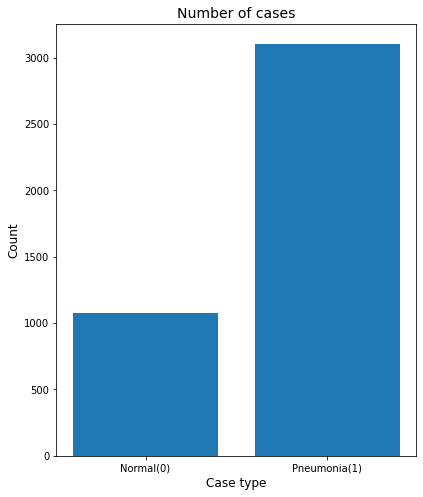

In [11]:
cases_count = np.bincount(train_set.classes)
print(cases_count)

# Plot the results 
fig = mpt.figure(figsize=(5,6))
ax = fig.add_axes([0,0,1,1])
img = train_set.class_indices.keys()
ax.bar(img, cases_count)
mpt.title('Number of cases', fontsize=14)
mpt.xlabel('Case type', fontsize=12)
mpt.ylabel('Count', fontsize=12)
mpt.xticks(range(len(train_set.class_indices)), ['Normal(0)', 'Pneumonia(1)'])
mpt.show()

The number of data for Pneumonia is three time higher than the one for Normal, we need to set weights to equilibrate ours models

In [12]:
# Weight balancing
weight_pneumo = 1
weight_normal = 3
class_weight = {0: weight_normal, 1: weight_pneumo}

## CNN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4014

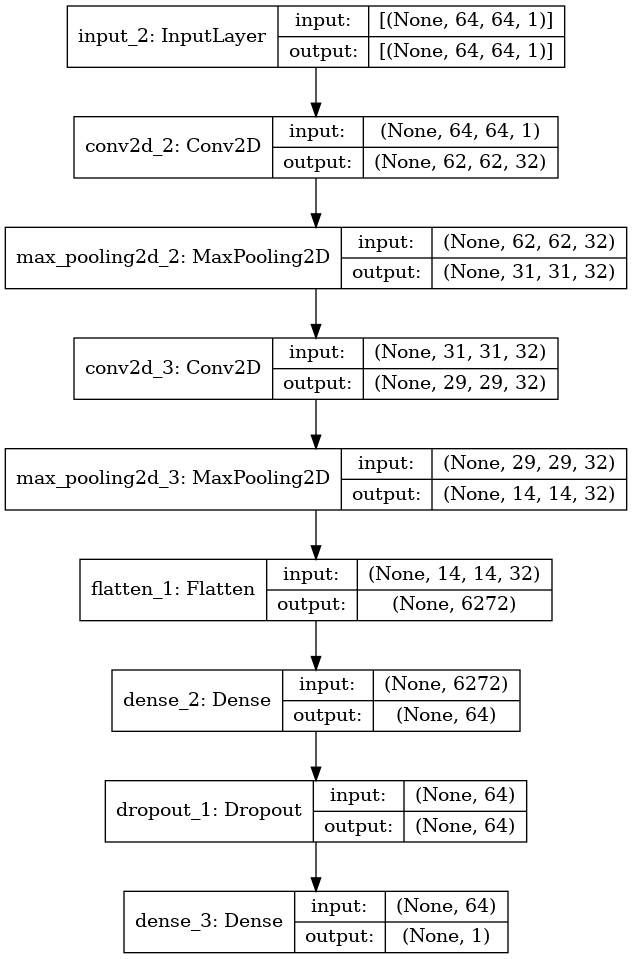

In [14]:
# Create model
def cnn():
  inputs = Input(shape=(64, 64, 1))
  conv_1 = Conv2D(32,(3,3), activation = "relu")(inputs)
  pool_1 = MaxPooling2D(pool_size = (2,2))(conv_1)
  conv_2 = Conv2D(32,(3,3), activation = "relu")(pool_1)
  pool_2 = MaxPooling2D(pool_size = (2,2))(conv_2)
  flat = Flatten()(pool_2)
  dense_1 = Dense(activation = 'relu', units = 64)(flat)
  drop = Dropout(0.2)(dense_1)
  dense_2 = Dense(activation = 'sigmoid', units = 1)(drop)
  model = Model(inputs=inputs, outputs=dense_2)
  return model

model_1 = cnn()
plot_model(model_1,show_shapes=True, show_layer_names=True)
print(model_1.summary())
plot_model(model_1, to_file="model_cnn_pneumo.png",
               show_shapes=True, show_layer_names=True)

In [15]:
# Compile model
model_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
# Fit model
model_cnn = model_1.fit(train_set, validation_data = val_set, epochs=10, batch_size=128, class_weight=class_weight)

2022-10-27 12:45:47.117324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
131/131 [==============================] - 90s 684ms/step - loss: 0.7244 - accuracy: 0.7429 - val_loss: 0.2994 - val_accuracy: 0.7430
Epoch 2/10
131/131 [==============================] - 57s 436ms/step - loss: 0.4397 - accuracy: 0.7429 - val_loss: 0.2600 - val_accuracy: 0.7430
Epoch 3/10
131/131 [==============================] - 57s 435ms/step - loss: 0.4114 - accuracy: 0.7429 - val_loss: 0.2725 - val_accuracy: 0.7430
Epoch 4/10
131/131 [==============================] - 57s 437ms/step - loss: 0.3887 - accuracy: 0.7429 - val_loss: 0.2849 - val_accuracy: 0.7430
Epoch 5/10
131/131 [==============================] - 57s 438ms/step - loss: 0.3737 - accuracy: 0.7429 - val_loss: 0.3365 - val_accuracy: 0.7430
Epoch 6/10
131/131 [==============================] - 58s 441ms/step - loss: 0.3447 - accuracy: 0.7429 - val_loss: 0.2312 - val_accuracy: 0.7430
Epoch 7/10
131/131 [==============================] - 58s 441ms/step - loss: 0.3313 - accuracy: 0.7429 - val_loss: 0.2375 - val_ac

In [17]:
# Evaluate model
model_1.evaluate(test_set)

1/1 [==============================] - 6s 6s/step - loss: 0.3377 - accuracy: 0.6250


[0.3377126157283783, 0.625]

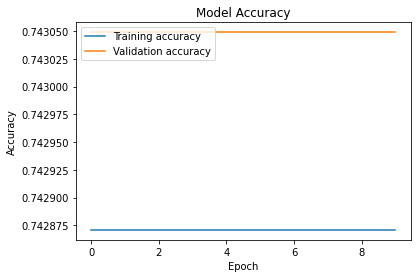

In [18]:
# Plot accuracy 
mpt.plot(model_cnn.history['accuracy'])
mpt.plot(model_cnn.history['val_accuracy'])
mpt.title('Model Accuracy')
mpt.ylabel('Accuracy')
mpt.xlabel('Epoch')
mpt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
mpt.show()

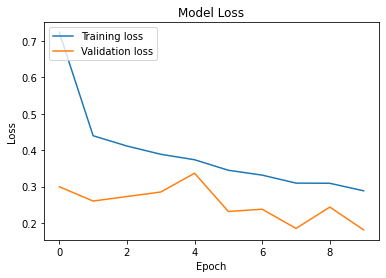

In [19]:
# Plot loss 
mpt.plot(model_cnn.history['loss'])
mpt.plot(model_cnn.history['val_loss'])
mpt.title('Model Loss')
mpt.ylabel('Loss')
mpt.xlabel('Epoch')
mpt.legend(['Training loss', 'Validation loss'], loc='upper left')
mpt.show()

In [20]:
# Split test dataset into x and y
x_test, y_test = next(test_set)

# Predict
y_predict_cnn = model_1.predict(x_test)

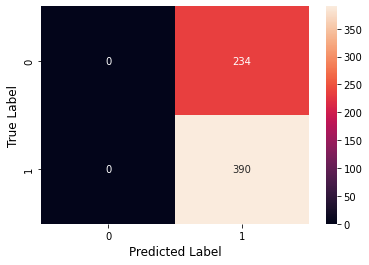

In [21]:
# Plot heatmap
pred_labels_cnn= np.where(y_predict_cnn>0.5, 1, 0)
sns.heatmap(confusion_matrix(y_test, pred_labels_cnn),fmt='g', annot=True)
mpt.xlabel("Predicted Label", fontsize= 12)
mpt.ylabel("True Label", fontsize= 12)

mpt.show()

In [18]:
print(classification_report(y_test, pred_labels_cnn, target_names=test_set.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.89      0.74      0.81       234
   PNEUMONIA       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



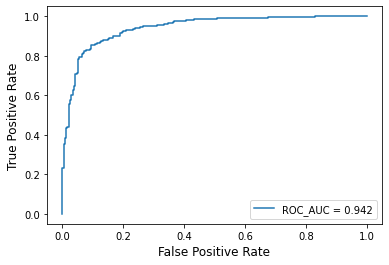

In [19]:
# Plot ROC curve

roc_auc = roc_auc_score(y_test, y_predict_cnn)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_cnn)

mpt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

mpt.xlabel("False Positive Rate", fontsize= 12)
mpt.ylabel("True Positive Rate", fontsize= 12)
mpt.legend(loc="lower right")

mpt.show()

print(classification_report(y_test, pred_labels_cnn, target_names=test_set.class_indices.keys()))## RESNET

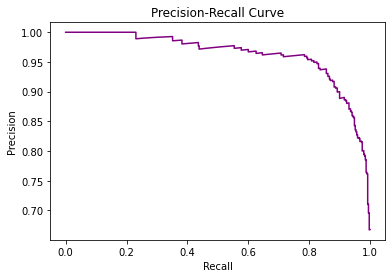

In [23]:
# Plot Precision-Recall curve


#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_cnn)

#create precision recall curve
fig, ax = mpt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
mpt.show()




`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


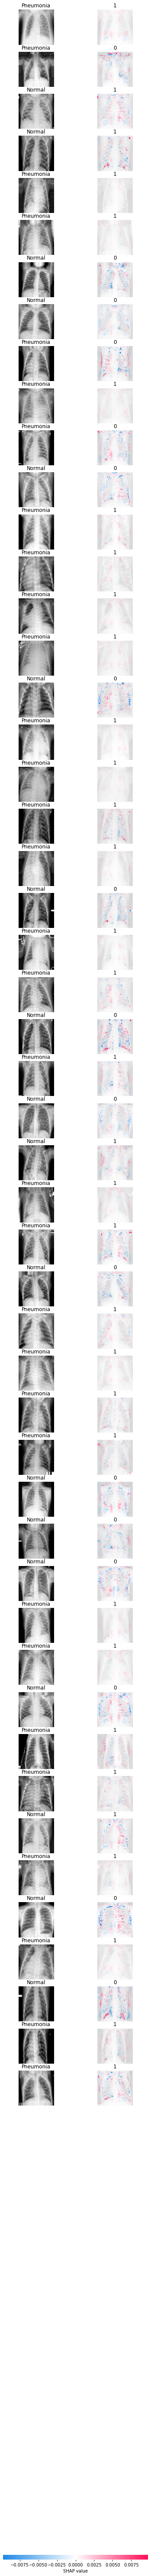

In [35]:
x = shap.DeepExplainer(model_1, x_test)
shap_values = x.shap_values(x_test[:100])
ind_names = list(map(str, y_test))
for i in range(len(ind_names)):
  if ind_names[i] == "0.0" :
    ind_names[i] = 'Normal'
  elif ind_names[i] == "1.0" :
    ind_names[i] = 'Pneumonia'
    
shap.image_plot(shap_values[0][:50], x_test[:50], true_labels = ind_names[:50], labels = pred_labels_cnn[:50])

In [26]:
# Creat ResNet module
def residual_module(lay_i):
    conv_0 = Conv2D(32,(1), padding="same", activation = "relu")(lay_i)
    save = conv_0
    conv_1 = Conv2D(16,(1, 1), padding="same", activation = "relu")(conv_0)
    conv_2 = Conv2D(16,(3, 3), padding="same", activation = "relu")(conv_1)
    conv_3 = Conv2D(32,(1, 1), padding="same", activation = "relu")(conv_2)
    conc_1 = Add()([conv_3, save])
    output = Activation("relu")(conc_1)
    return output

# Create ResNet
def resnet():
    n_residual = 5
    print("Simple residual network with {} modules".format(n_residual))
    inputs = Input(shape=(64, 64, 1))
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i)


    gavg_1 = MaxPooling2D(pool_size = (2,2))(residual_i)
    flat_1 = Flatten()(gavg_1)
    dense = Dense(32, activation="relu")(flat_1)
    drop = Dropout(0.2)(dense)
    output = Dense(1, activation="sigmoid")(drop)
    model = Model(inputs=inputs, outputs=output)

    return model

Simple residual network with 5 modules
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   64          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 16)   528         conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   2320        conv2d_3[0][0]                   
_____________________________________________________

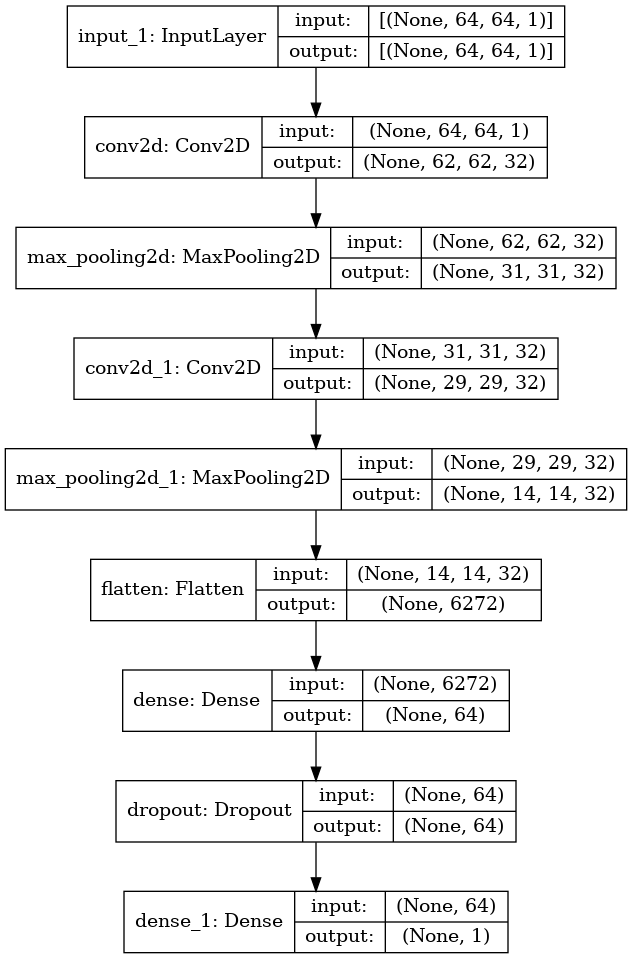

In [27]:
# Plot ResNet model
model_2 = resnet()
plot_model(model_2, to_file="residual.png",
               show_shapes=True, show_layer_names=True)
print(model_2.summary())
plot_model(model_1, to_file="model_cnn_pneumo.png",
               show_shapes=True, show_layer_names=True)

In [29]:
# Compile model
model_2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [34]:
# Fit model
history_resnet = model_2.fit(train_set, validation_data = val_set, epochs=10, batch_size=128, class_weight=class_weight)

Epoch 1/10
131/131 [==============================] - 107s 802ms/step - loss: 0.7413 - accuracy: 0.6882 - val_loss: 0.3031 - val_accuracy: 0.8667
Epoch 2/10
131/131 [==============================] - 104s 793ms/step - loss: 0.4902 - accuracy: 0.8613 - val_loss: 0.4294 - val_accuracy: 0.8447
Epoch 3/10
131/131 [==============================] - 104s 793ms/step - loss: 0.4443 - accuracy: 0.8775 - val_loss: 0.2324 - val_accuracy: 0.8955
Epoch 4/10
131/131 [==============================] - 105s 798ms/step - loss: 0.3880 - accuracy: 0.8991 - val_loss: 0.2460 - val_accuracy: 0.8897
Epoch 5/10
131/131 [==============================] - 105s 799ms/step - loss: 0.3732 - accuracy: 0.8974 - val_loss: 0.2595 - val_accuracy: 0.9032
Epoch 6/10
131/131 [==============================] - 105s 798ms/step - loss: 0.3535 - accuracy: 0.9097 - val_loss: 0.2338 - val_accuracy: 0.9032
Epoch 7/10
131/131 [==============================] - 104s 793ms/step - loss: 0.4000 - accuracy: 0.9013 - val_loss: 0.2637 -

In [36]:
# Evaluate model
model_2.evaluate(x_test, y_test)

20/20 [==============================] - 2s 78ms/step - loss: 0.3275 - accuracy: 0.8542


[0.32747820019721985, 0.8541666865348816]

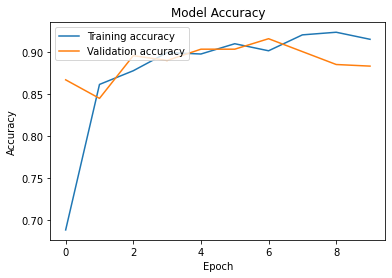

In [37]:
# Plot accuracy 
mpt.plot(history_resnet.history['accuracy'])
mpt.plot(history_resnet.history['val_accuracy'])
mpt.title('Model Accuracy')
mpt.ylabel('Accuracy')
mpt.xlabel('Epoch')
mpt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
mpt.show()

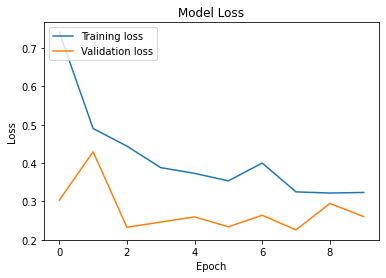

In [47]:
# Plot loss 
mpt.plot(history_resnet.history['loss'])
mpt.plot(history_resnet.history['val_loss'])
mpt.title('Model Loss')
mpt.ylabel('Loss')
mpt.xlabel('Epoch')
mpt.legend(['Training loss', 'Validation loss'], loc='upper left')
mpt.show()

In [39]:
# Predict
y_predict_resnet = model_2.predict(x_test)

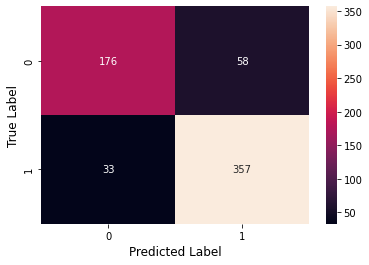

In [40]:
# Plot heatmap
pred_labels_resnet= np.where(y_predict_resnet>0.5, 1, 0)
sns.heatmap(confusion_matrix(y_test, pred_labels_resnet),fmt='g', annot=True)
mpt.xlabel("Predicted Label", fontsize= 12)
mpt.ylabel("True Label", fontsize= 12)

mpt.show()

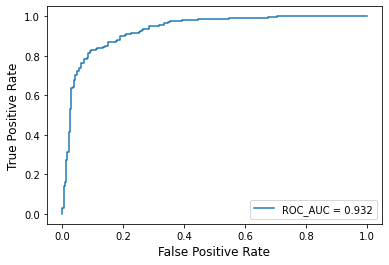

In [41]:
# Plot ROC curve
roc_auc = roc_auc_score(y_test, y_predict_resnet)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_resnet)

mpt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

mpt.xlabel("False Positive Rate", fontsize= 12)
mpt.ylabel("True Positive Rate", fontsize= 12)
mpt.legend(loc="lower right")

mpt.show()

In [42]:
print(classification_report(y_test, pred_labels_resnet, target_names=test_set.class_indices.keys()))

              precision    recall  f1-score   support

      NORMAL       0.84      0.75      0.79       234
   PNEUMONIA       0.86      0.92      0.89       390

    accuracy                           0.85       624
   macro avg       0.85      0.83      0.84       624
weighted avg       0.85      0.85      0.85       624



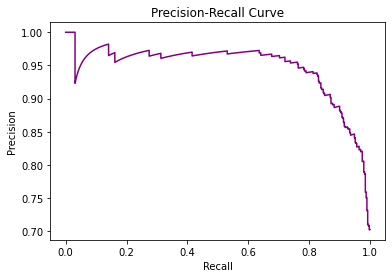

In [43]:
# Plot Precision-Recall curve



#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_predict_resnet)

#create precision recall curve
fig, ax = mpt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
mpt.show()



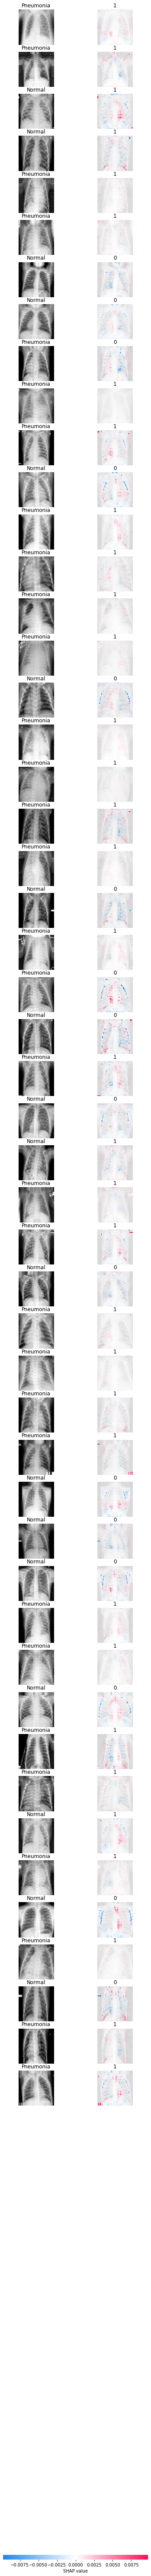

In [45]:
x = shap.DeepExplainer(model_2, x_test)
shap_values = x.shap_values(x_test[:100])
ind_names = list(map(str, y_test))
for i in range(len(ind_names)):
  if ind_names[i] == "0.0" :
    ind_names[i] = 'Normal'
  elif ind_names[i] == "1.0" :
    ind_names[i] = 'Pneumonia'
    
shap.image_plot(shap_values[0][:50], x_test[:50], true_labels = ind_names[:50], labels = pred_labels_resnet[:50])